# Ripple IMRPhenomD

Checking whether check_NRTidalv2 notebook is bugged by comparing with results obtained for IMRPhenomD

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2
from ripple.waveforms import IMRPhenomD
from ripple import get_match_arr, get_eff_pads
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt

import lalsimulation as lalsim
import lal

# To get plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

jax.config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [12]:
m1 = 10
m2 = 30

chi1 = 0.1
chi2 = 0.1

# lambda1 = 0
# lambda2 = lambda1

distance = 440.

Get the frequency grid:

In [13]:
# Frequency grid
T = 16
f_l = 16
f_sampling = 4096
# f_u = f_sampling // 2
f_u = 1024
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [14]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0.0
phic = 0.0
dist_mpc = distance
inclination = np.pi / 2.0

m1_kg = m1 * lal.MSUN_SI
m2_kg = m2 * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination])

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)

## LAL

In [15]:
IMRphenom = "IMRPhenomD"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)

freqs_lal = np.arange(len(hp.data.data)) * df
mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

## Comparison

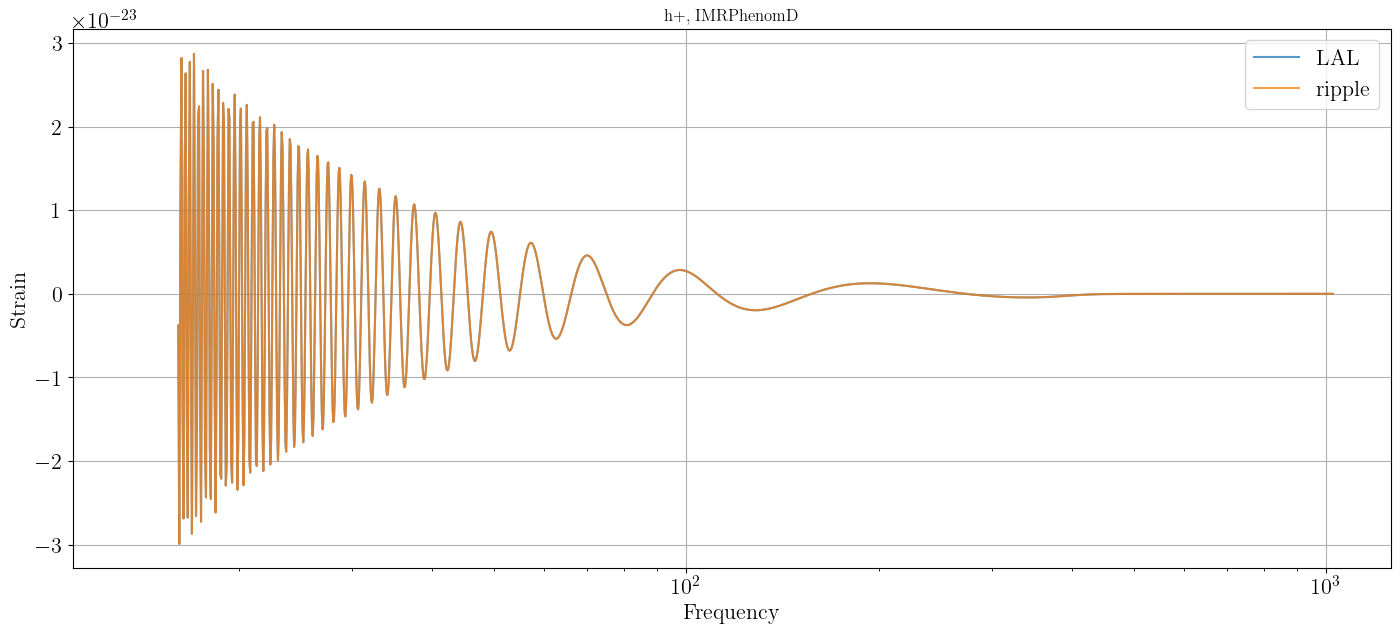

In [16]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(fs, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(fs, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, IMRPhenomD")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

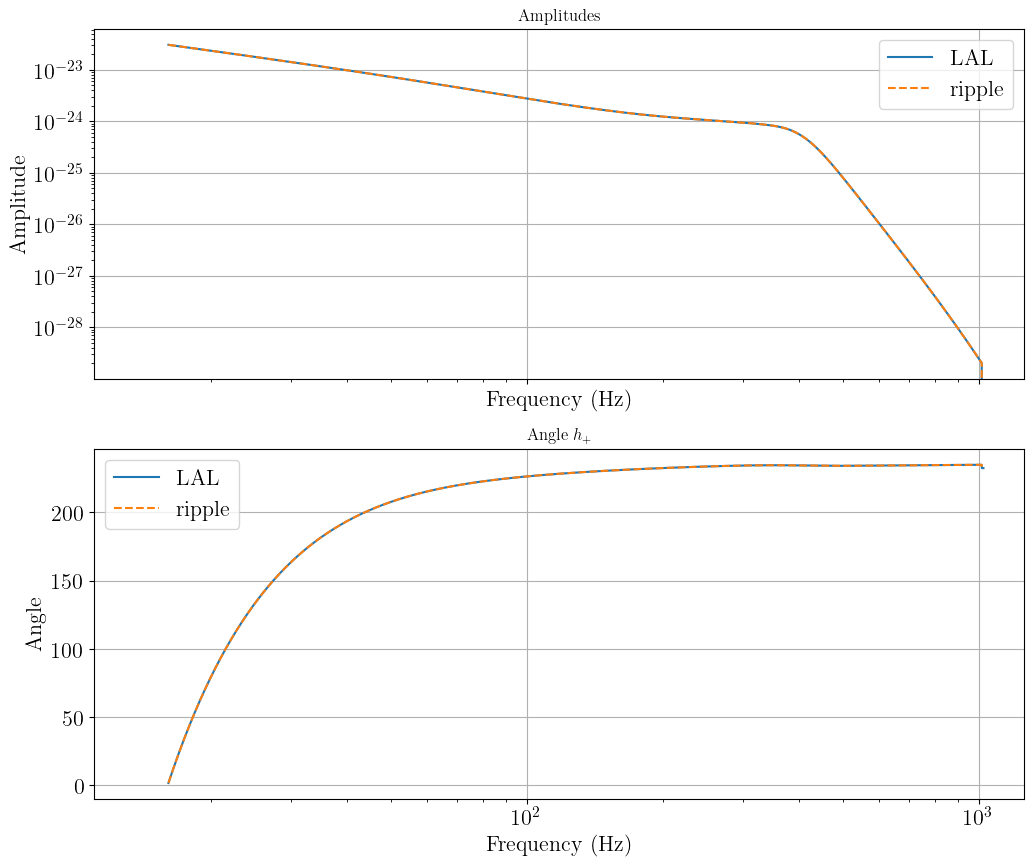

In [17]:
A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(fs, A_lalsuite, "-", label = "LAL")
plt.plot(fs, A_ripple, "--", label = "ripple")

# plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.title(r"Amplitudes")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
# plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(fs, angle_lalsuite, "-", label = "LAL")
    plt.plot(fs, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(fs, angle_lalsuite, "-", label = "LAL")
    plt.plot(fs, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
# plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.title(r"{} $h_+$ ".format(name))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

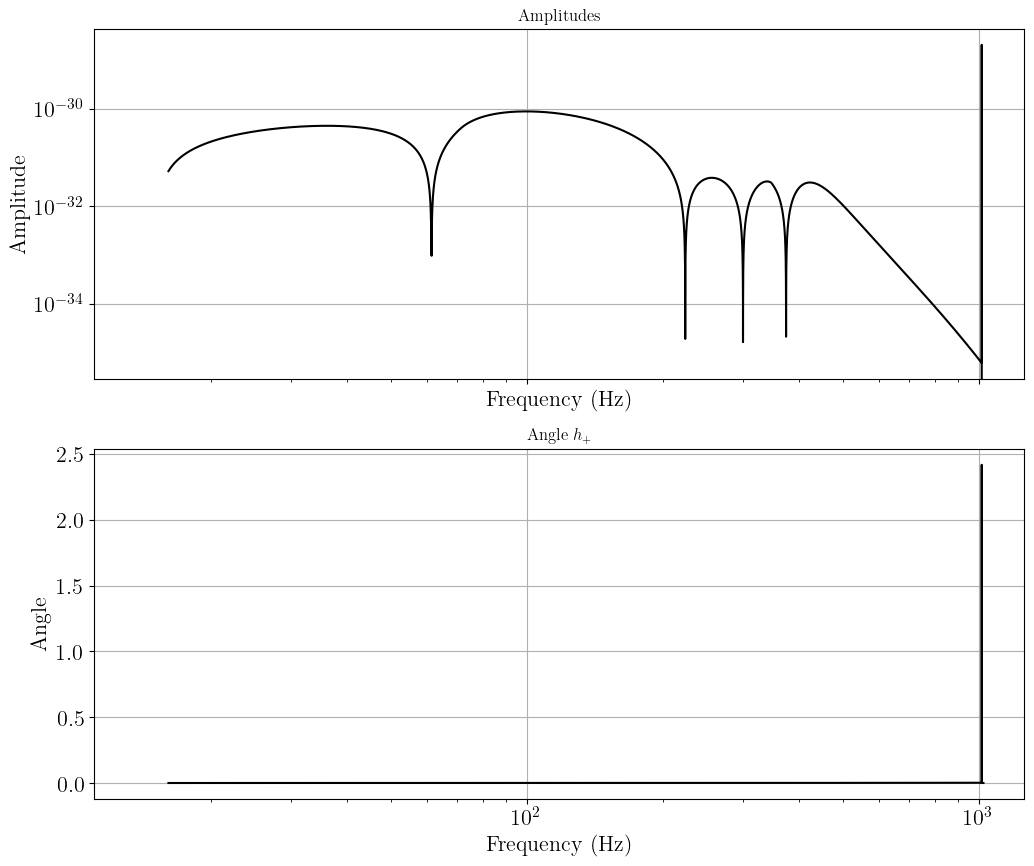

In [18]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(fs, diffs_amplitude, "-", color = "black")

# plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.title(r"Amplitudes")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
# plt.xlim(f_l - 5)

# Plot the angle or the phase
plt.subplot(2, 1, 2)
plt.plot(fs, abs(angle_lalsuite - angle_ripple), "-", color = "black")
name = "Angle"
# plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.title(r"{} $h_+$ ".format(name))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()


**Discussion:** Same remarks as above. For the angle, the spin-spin contributions could solve the increasing error in the second plot. For the amplitude: I am a bit surprised that the error in amplitude seems to be increasing with increasing frequency and I am not sure what is causing this. This will not be fixed by the Planck taper. Is there another bug in the implementation? 

# Debugging

## Computing mismatch

In [19]:
pad_low, pad_high = get_eff_pads(fs)
f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)
PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_lalsuite,
        hp_ripple,
    )

print(match)
print(np.log10(1 - match))

0.9999999891064459
-7.96283040708398
